# Retail Data Wrangling and Analytics

In [2]:
# Import modules 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Load Data from PSQL into DataFrame

**Setup Docker Containers**

![](https://i.imgur.com/VQrBVBk.jpg)

```
#make sure you have both Jupyter and PSQL docker container running
docker ps

#Attach a bridge network to both containers so they can communicate with each other
docker network create jarvis-net
#this command works on running containers
docker network connect jarvis-net jarvis-jupyter
docker network connect jarvis-net jarvis-psql

#verify both containers are attached to the jarvis-net
docker network inspect trading-net

#Note: instead of using `localhost`, you should use container names as hostnames.
```

**Data Preperation**

- Use [pandas.read_sql](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html) api to load the PSQL retail table into a Pandas DataFrame

![](https://i.imgur.com/AmkAP63.jpg)

- Get familair with the transaction date with `df.head()`, `df.sample(10)`, `df.info()`, `df.describe()`, etc..



In [3]:

!pip3 install -q psycopg2-binary sqlalchemy

In [4]:
from sqlalchemy import create_engine

PG_HOST = "jrvs-psql"       
PG_PORT = 5432               
PG_DB   = "postgres"
PG_USER = "postgres"
PG_PW   = "password"

engine_string = f"postgresql+psycopg2://{PG_USER}:{PG_PW}@{PG_HOST}:{PG_PORT}/{PG_DB}"
engine = create_engine(engine_string)

# Load table (schema-qualified)
retail_df = pd.read_sql_query("SELECT * FROM public.retail;", engine)

retail_df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
retail_df.info()
retail_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice_no    1067371 non-null  object        
 1   stock_code    1067371 non-null  object        
 2   description   1062989 non-null  object        
 3   quantity      1067371 non-null  int64         
 4   invoice_date  1067371 non-null  datetime64[ns]
 5   unit_price    1067371 non-null  float64       
 6   customer_id   824364 non-null   float64       
 7   country       1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


,quantity,unit_price,customer_id
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


# Load CSV into Dataframe
Alternatively, the LGS IT team also dumped the transactional data into a [CSV file](https://raw.githubusercontent.com/jarviscanada/jarvis_data_eng_demo/feature/data/python_data_wrangling/data/online_retail_II.csv). However, the CSV header (column names) doesn't follow the snakecase or camelcase naming convention (e.g. `Customer ID` instead of `customer_id` or `CustomerID`). As a result, you will need to use Pandas to clean up the data before doing any analytics. In addition, unlike the PSQL scheme, CSV files do not have data types associated. Therefore, you will need to cast/convert certain columns into correct data types (e.g. DateTime, numbers, etc..)

**Data Preperation**

- Read the `data/online_retail_II.csv` file into a DataFrame
- Rename all columns to upper camelcase or snakecase
- Convert/cast all columns to the appropriate data types (e.g. datetime)

In [13]:
retail_df = pd.read_csv("online_retail_II.csv")


retail_df = retail_df.rename(columns={
    "Invoice": "invoice_no",
    "StockCode": "stock_code",
    "Description": "description",
    "Quantity": "quantity",
    "InvoiceDate": "invoice_date",
    "Price": "unit_price",
    "Customer ID": "customer_id",
    "Country": "country"
})

retail_df["invoice_date"] = pd.to_datetime(
    retail_df["invoice_date"],
    errors="coerce"
)
retail_df["quantity"] = pd.to_numeric(retail_df["quantity"], errors="coerce")
retail_df["unit_price"] = pd.to_numeric(retail_df["unit_price"], errors="coerce")
retail_df["customer_id"] = pd.to_numeric(retail_df["customer_id"], errors="coerce")


retail_df.info()

retail_df.head()
retail_df.describe()

#create and clean copy for analysis
df = retail_df.copy()

df["invoice_date"] = pd.to_datetime(df["invoice_date"])
df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")
df["unit_price"] = pd.to_numeric(df["unit_price"], errors="coerce")
df["customer_id"] = pd.to_numeric(df["customer_id"], errors="coerce")


df["line_amount"] = df["quantity"] * df["unit_price"]
df["yyyymm"] = df["invoice_date"].dt.year * 100 + df["invoice_date"].dt.month
df["is_canceled"] = df["invoice_no"].astype(str).str.startswith("C")

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice_no    1067371 non-null  object        
 1   stock_code    1067371 non-null  object        
 2   description   1062989 non-null  object        
 3   quantity      1067371 non-null  int64         
 4   invoice_date  1067371 non-null  datetime64[ns]
 5   unit_price    1067371 non-null  float64       
 6   customer_id   824364 non-null   float64       
 7   country       1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,line_amount,yyyymm,is_canceled
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,200912,False
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,200912,False
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,200912,False
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,200912,False
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,200912,False


# Total Invoice Amount Distribution

min: -168469.6
max: 168469.6
median: 196.34499999999997
mean: 359.6488880435809
mode: 0.0


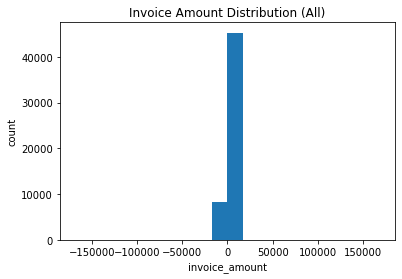

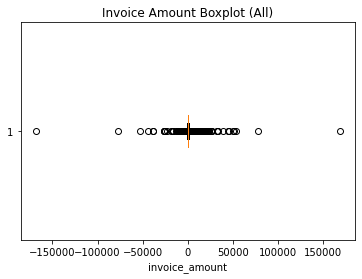

85% cap: 594.0095000000002
min: -168469.6
max: 594.0
median: 141.9
mean: 136.97756815040273
mode: 0.0


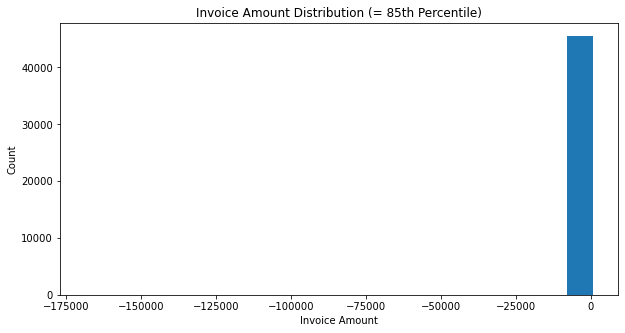

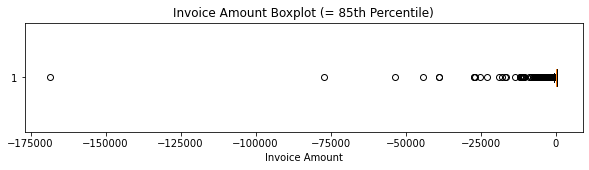

In [9]:

invoice_totals = (
    df.groupby("invoice_no", as_index=False)
      .agg(invoice_amount=("line_amount", "sum"))
)

invoice_totals.describe()


vals = invoice_totals["invoice_amount"].dropna()

print("min:", vals.min())
print("max:", vals.max())
print("median:", vals.median())
print("mean:", vals.mean())
print("mode:", vals.mode().iloc[0] if not vals.mode().empty else np.nan)

plt.figure()
plt.hist(vals, bins=20)
plt.title("Invoice Amount Distribution (All)")
plt.xlabel("invoice_amount")
plt.ylabel("count")
plt.show()

plt.figure()
plt.boxplot(vals, vert=False)
plt.title("Invoice Amount Boxplot (All)")
plt.xlabel("invoice_amount")
plt.show()


q85 = vals.quantile(0.85)
vals_85 = vals[vals <= q85]

print("85% cap:", q85)
print("min:", vals_85.min())
print("max:", vals_85.max())
print("median:", vals_85.median())
print("mean:", vals_85.mean())
print("mode:", vals_85.mode().iloc[0] if not vals_85.mode().empty else np.nan)

plt.figure(figsize=(10, 5))
plt.hist(vals_85, bins=20)
plt.title("Invoice Amount Distribution (= 85th Percentile)")
plt.xlabel("Invoice Amount")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 2))
plt.boxplot(vals_85, vert=False)
plt.title("Invoice Amount Boxplot (= 85th Percentile)")
plt.xlabel("Invoice Amount")
plt.show()




# Monthly Placed and Canceled Orders

In [15]:
invoice_level = (
    df.groupby(["yyyymm", "invoice_no"], as_index=False)
      .agg(is_canceled=("is_canceled", "max"))
)

monthly = (
    invoice_level.groupby("yyyymm", as_index=False)
    .agg(
        total_invoices=("invoice_no", "nunique"),
        canceled_invoices=("is_canceled", "sum")
    )
    .sort_values("yyyymm")
)

monthly["canceled_orders"] = monthly["canceled_invoices"]

monthly["placed_orders"] = monthly["total_invoices"] - (2*monthly["canceled_orders"])

monthly.head()

,yyyymm,total_invoices,canceled_invoices,canceled_orders,placed_orders
0,200912,2330,401,401,1528
1,201001,1633,300,300,1033
2,201002,1969,240,240,1489
3,201003,2367,407,407,1553
4,201004,1892,304,304,1284


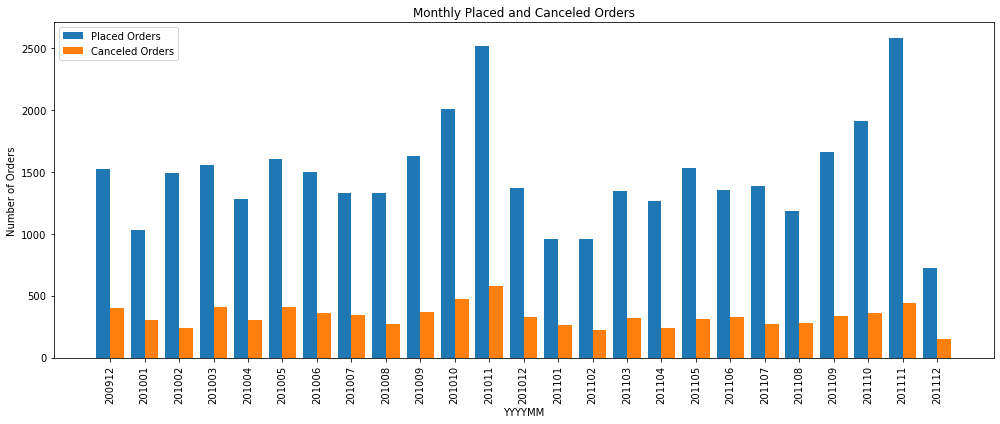

In [16]:
# X positions
x = np.arange(len(monthly["yyyymm"]))
bar_width = 0.4

plt.figure(figsize=(14, 6))


plt.bar(
    x - bar_width / 2,
    monthly["placed_orders"],
    width=bar_width,
    label="Placed Orders"
)

plt.bar(
    x + bar_width / 2,
    monthly["canceled_orders"],
    width=bar_width,
    label="Canceled Orders"
)

plt.xticks(x, monthly["yyyymm"].astype(str), rotation=90)
plt.xlabel("YYYYMM")
plt.ylabel("Number of Orders")
plt.title("Monthly Placed and Canceled Orders")
plt.legend()
plt.tight_layout()
plt.show()



# Monthly Sales

In [18]:

df = retail_df.copy()

df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")

df["yyyymm"] = df["invoice_date"].dt.year * 100 + df["invoice_date"].dt.month

df["line_amount"] = df["quantity"] * df["unit_price"]

df["is_canceled"] = df["invoice_no"].astype(str).str.startswith("C")
sales_df = df[~df["is_canceled"]].copy()

monthly_sales = (
    sales_df.groupby("yyyymm", as_index=False)
            .agg(monthly_sales=("line_amount", "sum"))
            .sort_values("yyyymm")
)

monthly_sales.head()

,yyyymm,monthly_sales
0,200912,825685.760
1,201001,652708.502
2,201002,553339.736
3,201003,833570.131
4,201004,627934.632


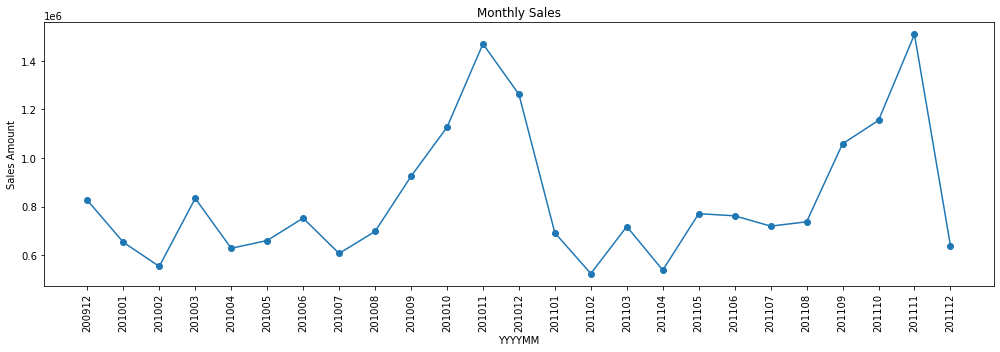

In [19]:
plt.figure(figsize=(14, 5))
plt.plot(monthly_sales["yyyymm"].astype(str), monthly_sales["monthly_sales"], marker="o")
plt.xticks(rotation=90)
plt.title("Monthly Sales")
plt.xlabel("YYYYMM")
plt.ylabel("Sales Amount")
plt.tight_layout()
plt.show()


# Monthly Sales Growth


In [21]:
ms = monthly_sales.copy().sort_values("yyyymm")

# % growth vs previous month
ms["sales_growth_pct"] = ms["monthly_sales"].pct_change() * 100
ms["sales_growth_pct"] = ms["sales_growth_pct"].fillna(0)
ms.head()


,yyyymm,monthly_sales,sales_growth_pct
0,200912,825685.760,0.000000
1,201001,652708.502,-20.949527
2,201002,553339.736,-15.224065
3,201003,833570.131,50.643461
4,201004,627934.632,-24.669250


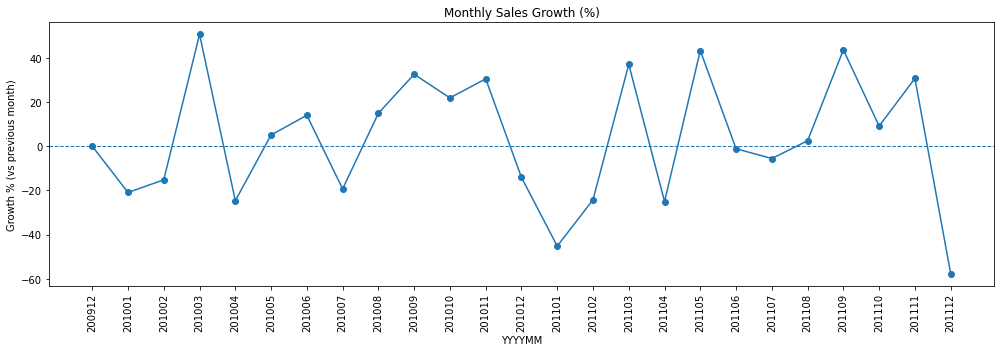

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(ms["yyyymm"].astype(str), ms["sales_growth_pct"], marker="o")
plt.axhline(0, linestyle="--", linewidth=1)  # baseline
plt.xticks(rotation=90)
plt.title("Monthly Sales Growth (%)")
plt.xlabel("YYYYMM")
plt.ylabel("Growth % (vs previous month)")
plt.tight_layout()
plt.show()


# Monthly Active Users

In [24]:
retail_df["invoice_date"] = pd.to_datetime(retail_df["invoice_date"], errors="coerce")

# Create yyyymm
retail_df["yyyymm"] = retail_df["invoice_date"].dt.year * 100 + retail_df["invoice_date"].dt.month

monthly_active_users = (
    retail_df.groupby("yyyymm", as_index=False)
             .agg(active_users=("customer_id", "nunique"))
             .sort_values("yyyymm")
)

monthly_active_users.head()



,yyyymm,active_users
0,200912,1045
1,201001,786
2,201002,807
3,201003,1111
4,201004,998


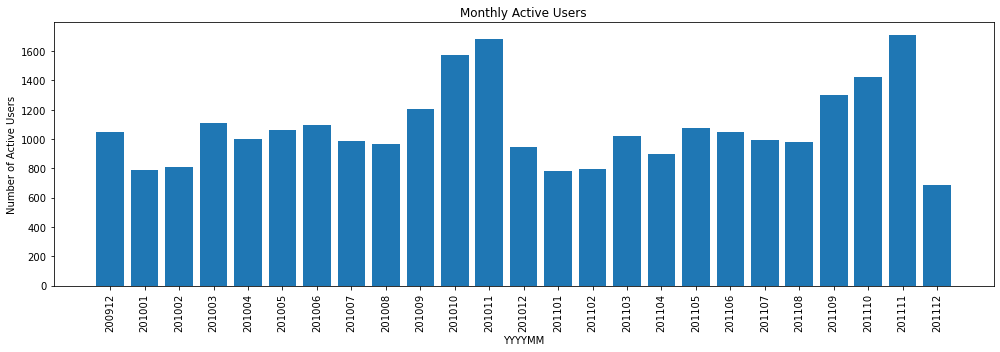

In [25]:
plt.figure(figsize=(14, 5))
plt.bar(monthly_active_users["yyyymm"].astype(str), monthly_active_users["active_users"])
plt.xticks(rotation=90)
plt.title("Monthly Active Users")
plt.xlabel("YYYYMM")
plt.ylabel("Number of Active Users")
plt.tight_layout()
plt.show()


# New and Existing Users



In [26]:
retail_df["invoice_date"] = pd.to_datetime(retail_df["invoice_date"], errors="coerce")
retail_df["yyyymm"] = retail_df["invoice_date"].dt.year * 100 + retail_df["invoice_date"].dt.month

#clean rows
df_users = retail_df.dropna(subset=["customer_id"]).copy()

first_month = (
    df_users.groupby("customer_id", as_index=False)
            .agg(first_yyyymm=("yyyymm", "min"))
)
first_month.head()

df_users = df_users.merge(first_month, on="customer_id", how="left")

#new user if month is first purchase  month
df_users["is_new_user"] = df_users["yyyymm"] == df_users["first_yyyymm"]

monthly_new_existing = (
    df_users.groupby("yyyymm")
            .agg(
                new_users=("customer_id", lambda s: s[df_users.loc[s.index, "is_new_user"]].nunique()),
                total_users=("customer_id", "nunique")
            )
            .reset_index()
            .sort_values("yyyymm")
)

monthly_new_existing["existing_users"] = monthly_new_existing["total_users"] - monthly_new_existing["new_users"]

monthly_new_existing.head()


,yyyymm,new_users,total_users,existing_users
0,200912,1045.0,1045,0.0
1,201001,394.0,786,392.0
2,201002,363.0,807,444.0
3,201003,436.0,1111,675.0
4,201004,291.0,998,707.0


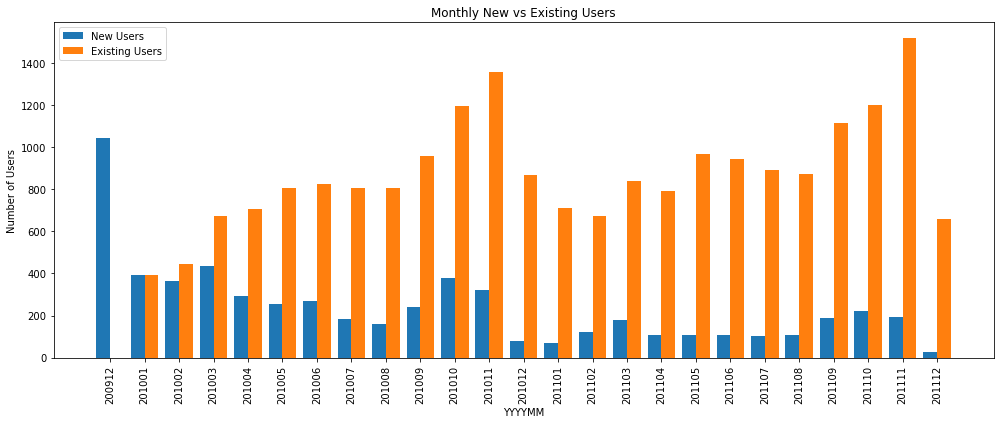

In [27]:
x = np.arange(len(monthly_new_existing["yyyymm"]))
w = 0.4

plt.figure(figsize=(14, 6))
plt.bar(x - w/2, monthly_new_existing["new_users"], width=w, label="New Users")
plt.bar(x + w/2, monthly_new_existing["existing_users"], width=w, label="Existing Users")

plt.xticks(x, monthly_new_existing["yyyymm"].astype(str), rotation=90)
plt.title("Monthly New vs Existing Users")
plt.xlabel("YYYYMM")
plt.ylabel("Number of Users")
plt.legend()
plt.tight_layout()
plt.show()


## Finding RFM

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in the retail and professional services industries. ([wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research)))

Optional Reading: [Making Your Database Pay Off Using Recency Frequency and Monetary Analysis](http://www.dbmarketing.com/2010/03/making-your-database-pay-off-using-recency-frequency-and-monetary-analysis/)


RFM stands for three dimensions:

- Recency – How recently did the customer purchase?

- Frequency – How often do they purchase?

- Monetary Value – How much do they spend?

Note: To simplify the problem, let's keep all placed and canceled orders.


**Sample RFM table**

![](https://i.imgur.com/sXFIg6u.jpg)

In [31]:
df = retail_df.copy()

df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")
df["invoice_day"] = df["invoice_date"].dt.normalize()

df["line_amount"] = df["quantity"] * df["unit_price"]

snapshot_day = pd.Timestamp("2011-12-10")

rfm = (
    df.dropna(subset=["customer_id"])
      .groupby("customer_id")
      .agg(
          recency=("invoice_day", lambda x: (snapshot_day - x.max()).days),
          frequency=("invoice_no", "nunique"),
          monetary=("line_amount", "sum")
      )
      .reset_index()
)

rfm.head()


#rfm.describe()


,customer_id,recency,frequency,monetary
0,12346.0,326,17,-64.68
1,12347.0,3,8,5633.32
2,12348.0,76,5,2019.40
3,12349.0,19,5,4404.54
4,12350.0,311,1,334.40


(Timestamp('2011-12-09 12:50:00'), Timestamp('2009-12-01 07:45:00'))

# RFM Segmentation

In [33]:

df = retail_df.copy()

# Ensure datetime
df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")

# TotalPrice (same concept as sample's TotalPrice)
df["total_price"] = df["unit_price"] * df["quantity"]

# Match sample cleaning: keep only positive transactions
df = df[df["quantity"] > 0]
df = df[df["total_price"] > 0]

df.dropna(inplace = True)


df.shape


(805549, 10)

In [35]:
df.describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95, 0.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
quantity,805549.0,13.290522,143.634088,1.000,1.00,1.00,1.00,2.00,5.00,12.00,24.00,36.0,128.00,80995.0
unit_price,805549.0,3.206561,29.199173,0.001,0.29,0.42,0.55,1.25,1.95,3.75,6.75,8.5,14.95,10953.5
customer_id,805549.0,15331.954970,1696.737039,12346.000,12422.00,12681.00,12979.00,13982.00,15271.00,16805.00,17716.00,17913.0,18204.00,18287.0
yyyymm,805549.0,201049.835433,56.244925,200912.000,200912.00,201001.00,201003.00,201007.00,201012.00,201107.00,201111.00,201111.0,201112.00,201112.0
total_price,805549.0,22.026505,224.041928,0.001,0.55,1.25,2.08,4.95,11.85,19.50,35.40,67.5,201.60,168469.6


In [34]:
today = pd.Timestamp(2012, 1, 1)


In [53]:
df_x = df.groupby('customer_id').agg({
    'total_price': lambda x: x.sum(),                        
    'invoice_date': lambda x: (today - x.max()).days           
})


df_y = df.groupby(['customer_id', 'invoice_no']).agg({
    'total_price': lambda x: x.sum()
})
df_y.columns = ['invoice_total']

df_z = df_y.groupby('customer_id').agg({
    'invoice_total': lambda x: len(x)
})
# creating the RFM table
rfm_table = pd.merge(df_x, df_z, on='customer_id')

rfm_table.rename(columns={
    'invoice_date': 'Recency',
    'invoice_total': 'Frequency',
    'total_price': 'Monetary'
}, inplace=True)

rfm_table.head()


,Monetary,Recency,Frequency
customer_id,,,
12346.0,77556.46,347,12.0
12347.0,5633.32,24,8.0
12348.0,2019.40,97,5.0
12349.0,4428.69,40,4.0
12350.0,334.40,332,1.0


In [40]:
# RFM score values (exact sample style / same column names)
rfm_table["RecencyScore"] = pd.qcut(rfm_table["Recency"], 5, labels=[5,4,3,2,1])
rfm_table["FrequencyScore"] = pd.qcut(rfm_table["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm_table["MonetaryScore"] = pd.qcut(rfm_table["Monetary"], 5, labels=[1,2,3,4,5])

rfm_table.head()



,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore
customer_id,,,,,,
12346.0,77556.46,347,12.0,2,5,5
12347.0,5633.32,24,8.0,5,4,5
12348.0,2019.40,97,5.0,3,4,4
12349.0,4428.69,40,4.0,5,3,5
12350.0,334.40,332,1.0,2,1,2


In [41]:
#RFM score values are combined side by side in str format
(rfm_table['RecencyScore'].astype(str) + 
 rfm_table['FrequencyScore'].astype(str) + 
 rfm_table['MonetaryScore'].astype(str)).head()

customer_id
12346.0    255
12347.0    545
12348.0    344
12349.0    535
12350.0    212
dtype: object

In [42]:
#calculation of the RFM score
rfm_table["RFM_SCORE"] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)

rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
customer_id,,,,,,,
12346.0,77556.46,347,12.0,2,5,5,255
12347.0,5633.32,24,8.0,5,4,5,545
12348.0,2019.40,97,5.0,3,4,4,344
12349.0,4428.69,40,4.0,5,3,5,535
12350.0,334.40,332,1.0,2,1,2,212


In [45]:
rfm_table.describe().T
rfm_table[rfm_table["RFM_SCORE"] == "555"].head()
rfm_table[rfm_table["RFM_SCORE"] == "111"].head()


,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
customer_id,,,,,,,
12387.0,143.94,437,1.0,1,1,1,111
12392.0,234.75,613,1.0,1,1,1,111
12400.0,205.25,436,1.0,1,1,1,111
12404.0,63.24,704,1.0,1,1,1,111
12416.0,202.56,678,1.0,1,1,1,111


In [49]:

#segmenting of customers according to RecencyScore and FrequencyScore values
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

#creation of segment variable
rfm_table['Segment'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(seg_map, regex=True)

rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
customer_id,,,,,,,,
12346.0,77556.46,347,12.0,2,5,5,255,Can't Lose
12347.0,5633.32,24,8.0,5,4,5,545,Champions
12348.0,2019.40,97,5.0,3,4,4,344,Loyal Customers
12349.0,4428.69,40,4.0,5,3,5,535,Potential Loyalists
12350.0,334.40,332,1.0,2,1,2,212,Hibernating


In [50]:
rfm_table["Segment"].value_counts()


Hibernating            1522
Loyal Customers        1147
Champions               852
At Risk                 750
Potential Loyalists     713
About to Sleep          388
Need Attention          269
Promising               110
Can't Lose               71
New Customers            56
Name: Segment, dtype: int64